# Efficient Single-Core and Multi-Core Processing
-------------------
## Contents
- **Getting to know the available hardware [not graded]**
    - Total CPUs in the system - physical, logical
    - Total logical CPUs allocated to your session = Total processes (one thread each) you can run truly in parallel = Total threads you can run truly in parallel (within a single process)
- **Efficient Single-core Computing for Deconvolution [40 points]**
    - Utilizing single core efficiently - introduction to JIT
    - Vectorizing the convolution operation [10], compare correctness and execution time [10]
    - Vectorizing the RL function [5], compare correctness and execution time [10], comparing RL results via plotting [5]
- **Multi-core Computing for Deconvolution [60 points]**
    - Utilizing multiple threads and cores - thread pool, process pool, example
    - Observations and analytical exercises [35]
    - Processing multiple images in parallel with JIT conv2d [25]
-------------------

# [Section] Getting to know the available hardware [not graded]

In [25]:
import concurrent.futures # process Pool Executor
import math # for complex math operations
import time # for timing the execution
from timeit import Timer
from functools import partial

Let's begin by checking the number of total CPU threads (= logical cores) in the system

In [2]:
import psutil
psutil.cpu_count(logical=True)

160

These are the total number of logical cores available on the current cluster node. HAL is 4-way hyper-threaded i.e. each physical core is presented as 4 logical cores to the OS/program. This can be verified by:

In [3]:
psutil.cpu_count(logical=False)

40

So there exist 40 physical cores, which are used as 160 logical cores.

In [4]:
psutil.Process().cpu_affinity()

[0, 1, 2, 3]

Out of total 160 logical cores, the cores listed above are allocated to you to run your code. CPU cores are allocated in chunks of 4 (i.e., even if you requested 6, you will be given 8) due to 4-way hyper-threading. Logical cores are also called threads.

In [5]:
import os
len(os.sched_getaffinity(0)) # should be same as length of above list

4

This number determines the amount of software threads/processes that can execute truly in parallel in hardware in your current session (assuming no other demand on resources). In reality, the operating system scheduler will schedule threads for execution on hardware depending on current resource demand.

Read more about HAL hardware, hardware vs. software threads, and multi-threading vs. parallel processing: 
- https://wiki.ncsa.illinois.edu/display/ISL20/HAL+cluster
- https://towardsdatascience.com/demystifying-python-multiprocessing-and-multithreading-9b62f9875a27
- https://stackoverflow.com/questions/5593328/software-threads-vs-hardware-threads
- https://stackoverflow.com/questions/19324306/running-two-threads-at-the-same-time
-------------------------

# [Section] Efficient Single-core Computing for Deconvolution [40 points]

### Just-in-time (JIT) compilation and auto-optimization using the numba.jit decorator

Numba is a compiler for Python array and numerical functions (code that uses NumPy arrays and functions, and loops) that gives you the power to speed up your applications with high performance functions written directly in Python.

Numba generates optimized machine code from pure Python code using the LLVM compiler infrastructure (LLVM began as a research project at UIUC! - https://llvm.org/). With a few simple decorators, array-oriented and math-heavy Python code can be just-in-time optimized to performance similar as C, C++ and Fortran, without having to switch languages or Python interpreters.

<!-- Numba is a just-in-time compiler for Python that works best on code that uses NumPy arrays and functions, and loops. The most common way to use Numba is through its collection of decorators that can be applied to your functions to instruct Numba to compile them.  -->
<!-- When a call is made to a Numba-decorated function it is compiled to machine code “just-in-time” for execution and all or part of your code can subsequently run at native machine code speed! -->

Numba reads the Python bytecode for a decorated function and combines this with information about the types of the input arguments to the function. It analyzes and optimizes your code, and finally uses the LLVM compiler library to generate a machine code version of your function, tailored to your CPU capabilities. This compiled version is then used every time your function is called.

In this MP, we make use of the following benefits of Numba's `@jit` decorator:
- just-in-time compilation to generate and cache native machine code
- automatic optimization/vectorization of user code

Read more for other benefits - https://numba.readthedocs.io/en/stable/user/5minguide.html, https://numba.readthedocs.io/en/stable/user/overview.html

Let's consider an example to observe the difference with and without using numba.jit

In [26]:
from numba import jit, int32
import numpy as np

def f(a):
    trace = 0.0
    for i in range(a.shape[0]):
        trace += np.tanh(a[i, i])
    return a + trace

@jit('double[:, :](int64[:, :])', nopython=True)
def f_numba(a): # Function is compiled and runs in machine code
    trace = 0.0
    for i in range(a.shape[0]):
        trace += np.tanh(a[i, i])
    return a + trace

In [27]:
import time

x = np.arange(10000).reshape(100, 100)

start = time.perf_counter()
f(x)
end = time.perf_counter()
print("Elapsed (no jit) = {}s".format((end - start)))

start = time.perf_counter()
f_numba(x)
end = time.perf_counter()
print("Elapsed (jit with compilation) = {}s".format((end - start)))

start = time.perf_counter()
f_numba(x)
end = time.perf_counter()
print("Elapsed (jit after compilation) = {}s".format((end - start)))

Elapsed (no jit) = 0.0006819348782300949s
Elapsed (jit with compilation) = 0.00032328441739082336s
Elapsed (jit after compilation) = 0.00013500917702913284s


<!-- In the first jit call, the function is compiled and cached. The time elapsed includes this compilation time. For subsequent jit calls, the compiled version is re-executed from cache, and is much faster than the same function without jit. -->

Numba has to compile your function for the argument types given before it executes the machine code version of your function. This takes time. However, once the compilation has taken place Numba caches the machine code version of your function for the particular types of arguments presented. If it is called again with the same types, it can reuse the cached version instead of having to compile again.

Now let's try to jit the 2d-convolution function, and see how that changes the performance of the RL algorithm.

### Put your ```convolution2d``` function below. (Ignore striding and call this function with sufficient padding such that the output size is same as input size.)

In [28]:
def convolve2D(image, kernel, padding):
    kernel = np.flipud(np.fliplr(kernel))
    padding = (len(kernel) - 1) / 2
    padding = math.ceil(padding)
    
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    
    output = np.zeros(image.shape)
    resize = []
    if (len(kernel) % 2 == 0):
        resize = np.zeros((len(image) + padding, len(image[0]) + padding))
    else:
        resize = np.zeros((len(image) + 2*padding, len(image[0]) + 2*padding))
        
    #fill in image resized:
    for i in range(len(image)):
        for j in range(len(image[0])):
            resize[i + padding][j + padding] = image[i][j]    
    
    for y in range(image.shape[1]):
        for x in range(image.shape[0]):
            output[x, y] = (kernel * resize[x: x + xKernShape, y: y + yKernShape]).sum()
    
    return output

### Put your ```richardson_lucy``` (2D) function from MP2/released solution in the cell below

In [58]:
def richardson_lucy(image, psf, num_iter=20, clip=True, filter_epsilon=None):
    psf_flip = np.flip(psf)
    im_deconv = np.ones(image.shape)
    
    for i in range(num_iter):
        conv = convolve2D(im_deconv, psf,0) + 1e-12
        rel_blur = image / conv
        im_deconv = im_deconv * convolve2D(rel_blur, psf_flip,0)
    
    return im_deconv

### JIT'ing the convolution function [10]

In [30]:
@jit(nopython=True)
def fast_convolution(image, kernel, padding):
    kernel = np.flipud(np.fliplr(kernel))
    padding = (len(kernel) - 1) / 2
    padding = math.ceil(padding)
    
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    
    output = np.zeros(image.shape)
    resize = [np.float64(x) for x in range(0)]
    if (len(kernel) % 2 == 0):
        resize = np.zeros((len(image) + padding, len(image[0]) + padding))
    else:
        resize = np.zeros((len(image) + 2*padding, len(image[0]) + 2*padding))
        
    #fill in image resized:
    for i in range(len(image)):
        for j in range(len(image[0])):
            resize[i + padding][j + padding] = image[i][j]    
    
    for y in range(image.shape[1]):
        for x in range(image.shape[0]):
            output[x, y] = (kernel * resize[x: x + xKernShape, y: y + yKernShape]).sum()
    
    return output

<!-- We can apply vectorization and JIT compilation to boost the performance of convolution!

Put your `convolve2D` function below, and compile it in a vectorization invokation with `jit`. Specify the expected input output datatypes in the jit call.

(Hint: read [`@jit` reference](https://numba.readthedocs.io/en/stable/user/jit.html)) -->

In [13]:
# Numba'ing the convolve2D function with the JIT compiler
#fast_convolution = ...

### Now let's test both a) correctness and b) performance of both the normal convolve2D and its optimized version. [10]

In [15]:
array_a = np.random.random_sample(size=(1033, 1033))
array_b = np.random.random_sample(size=(37, 37))

start_slow = time.perf_counter()
slow_result = convolve2D(array_a, array_b, 0)
end_slow = time.perf_counter()

start_fast = time.perf_counter()
fast_result = fast_convolution(array_a, array_b, 0)
end_fast = time.perf_counter()

# compare correctness
print("Slow Result")
#print(slow_result) # 4 x 3 - same as input since mode="same"

print()

print("Fast Result")
#print(fast_result)

print("\nYour result is {}".format("correct!" if np.allclose(
    slow_result, fast_result) else "incorrect."))


# compare time
computation_time_vanilla = end_slow - start_slow
computation_time_vectorized = end_fast - start_fast

print("Computation time is %0.9f without vectorization" % computation_time_vanilla)
print("Computation time is %0.9f using vectorization" %
      computation_time_vectorized)

Slow Result

Fast Result

Your result is correct!
Computation time is 12.893152665 without vectorization
Computation time is 4.330430037 using vectorization


In [16]:
print(slow_result)
print("-------------")
print(fast_result)

[[ 97.68812047 100.6296833  108.92799866 ... 103.77126375  96.09711784
   91.37849741]
 [101.76280465 108.59525911 112.15479298 ... 104.26258511 101.86435389
   95.57261126]
 [110.272852   114.32444905 118.2793829  ... 109.5005434  106.77078009
  100.79202151]
 ...
 [ 94.39199953  98.03188601 101.81613889 ... 103.68569125 100.19728473
   91.26450711]
 [ 87.48636171  97.19651297  99.68015585 ...  99.50461554  96.14032885
   88.40342958]
 [ 83.06353581  88.71061841  90.75298059 ...  94.38766466  88.71476012
   82.6339085 ]]
-------------
[[ 97.68812047 100.6296833  108.92799866 ... 103.77126375  96.09711784
   91.37849741]
 [101.76280465 108.59525911 112.15479298 ... 104.26258511 101.86435389
   95.57261126]
 [110.272852   114.32444905 118.2793829  ... 109.5005434  106.77078009
  100.79202151]
 ...
 [ 94.39199953  98.03188601 101.81613889 ... 103.68569125 100.19728473
   91.26450711]
 [ 87.48636171  97.19651297  99.68015585 ...  99.50461554  96.14032885
   88.40342958]
 [ 83.06353581  88

### The natural next step - upgrading the Richardson-Lucy Deconvolution with the optimized convolution [5]

Let's drop in the vectorized convolution into the RL algorithm to get a vectorized RL implementation.

In [59]:
def richardson_lucy_vectorized(image, psf, num_iter=20, clip=True, filter_epsilon=None):
    psf_flip = np.flip(psf)
    im_deconv = np.ones(image.shape)
    
    for i in range(num_iter):
        conv = fast_convolution(im_deconv, psf,0) + 1e-12
        rel_blur = image / conv
        im_deconv = im_deconv * fast_convolution(rel_blur, psf_flip,0)
    
    return im_deconv

### Again, test both a) correctness and b) the execution time of the vectorized Richardson-Lucy deconvolution compared to the regular implementation. [10]

In [32]:
import PIL.Image

from skimage import color
import os

#os.chdir("/home/sthamm2/fa22_bioe488_sthamm2/resources")

brain = np.array(PIL.Image.open("resources/brain_MRI.png"))

if len(brain.shape) > 2:  # check if the picture has multiple color channels. If yes, convert to greyscale
    brain = color.rgb2gray(brain)

brain = brain / 256.  # normalize the image pixel data to [0,1]
brain += 1E-12  # adding a small constant 1E-12 to avoid division-by-zero later down the line

psf = np.ones((5, 5)) / 25

In [33]:
%cd /home/sthamm2/fa22_bioe488_sthamm2/MP3/

/home/sthamm2/fa22_bioe488_sthamm2/MP3


In [34]:
import concurrent
import time
import copy

# making copies of the same image
brains = [copy.copy(brain) for _ in range(3)]

print("--- [Non-vectorized] Starting the timer ---")
slow_start = time.perf_counter()
slow_deconv = richardson_lucy(brains[0], psf, num_iter=20)
slow_end = time.perf_counter()
print(f"--- Done: The execution took {slow_end - slow_start} seconds ---")


print("--- [Vectorized] Starting the timer ---")
fast_start = time.perf_counter()
fast_deconv = richardson_lucy_vectorized(brains[0], psf, 20)
fast_end = time.perf_counter()
print(f"--- Done: The execution took {fast_end - fast_start} seconds ---")

--- [Non-vectorized] Starting the timer ---
--- Done: The execution took 90.130481694825 seconds ---
--- [Vectorized] Starting the timer ---
--- Done: The execution took 4.5232103588059545 seconds ---


**Q: Can you explain why there is a difference in the run-time between the two?**

Your Answer:

- There exists a drastic time difference between the two implementations due to the aspect of vectorization. Through Numba's JIT addition, numba will automatically vectorize portions of the algorithm that is deemed fit for vectorization. Rather than modifying a single value in a call, vectorization will modify a set of values in a given call. Extrapolating this process in the scope of the RL algorithm, vectorization's effect is distinguishable. JIT compilation also accesses dynamic runtime information by storing the machine code rather than the bytecode, which bypasses the issue of recompilation of each method call. 

**Numerically compare both results below**

In [25]:
print("--- [Non-vectorized] Starting the timer ---")
print(slow_deconv)
print("\n--- [Vectorized] Starting the timer ---")
print(fast_deconv)

print("\n---They are the same?---")
print(np.allclose(slow_deconv, fast_deconv))

--- [Non-vectorized] Starting the timer ---
[[5.19077275e-22 1.31385690e-19 9.67277417e-18 ... 9.67277417e-18
  1.31385690e-19 5.19077275e-22]
 [1.31385690e-19 3.26760953e-17 2.37112035e-15 ... 2.37112035e-15
  3.26760953e-17 1.31385690e-19]
 [9.67277417e-18 2.37112035e-15 1.70002059e-13 ... 1.70002059e-13
  2.37112035e-15 9.67277417e-18]
 ...
 [9.67277417e-18 2.37112035e-15 1.70002059e-13 ... 1.70002059e-13
  2.37112035e-15 9.67277417e-18]
 [1.31385690e-19 3.26760953e-17 2.37112035e-15 ... 2.37112035e-15
  3.26760953e-17 1.31385690e-19]
 [5.19077275e-22 1.31385690e-19 9.67277417e-18 ... 9.67277417e-18
  1.31385690e-19 5.19077275e-22]]

--- [Vectorized] Starting the timer ---
[[5.19077275e-22 1.31385690e-19 9.67277417e-18 ... 9.67277417e-18
  1.31385690e-19 5.19077275e-22]
 [1.31385690e-19 3.26760953e-17 2.37112035e-15 ... 2.37112035e-15
  3.26760953e-17 1.31385690e-19]
 [9.67277417e-18 2.37112035e-15 1.70002059e-13 ... 1.70002059e-13
  2.37112035e-15 9.67277417e-18]
 ...
 [9.67277417e

### Now, lets qualitatively verify the result of the optimized deconvolution by plotting it against the regular version. [5]

Text(0.5, 1.0, 'Vectorized : Fast Deconv')

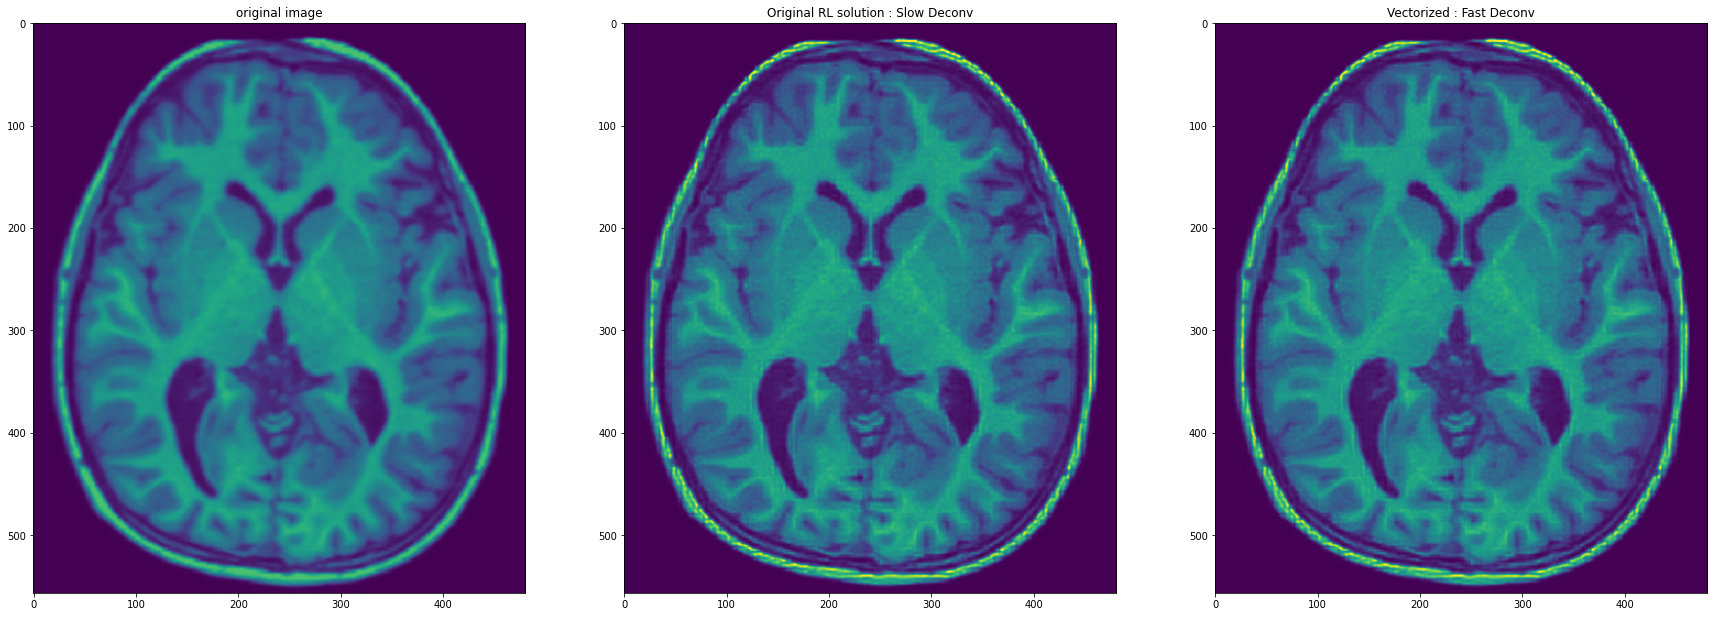

In [26]:
# Plot the original brain image, original RL solution, and vectorized RL solution
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 30))

ax1.imshow(brain, vmin=0, vmax=1)
ax1.set_title("original image")

ax2.imshow(slow_deconv, vmin=0, vmax=1)
ax2.set_title("Original RL solution : Slow Deconv")

ax3.imshow(fast_deconv, vmin=0, vmax=1)
ax3.set_title("Vectorized : Fast Deconv")

----------------

# [Section] Multi-core Computing for Deconvolution [60 points]

Watch [this video](https://www.youtube.com/watch?v=hwTYDQ0zZOw) (5 min)
and read [this tutorial](https://www.temok.com/blog/cores-vs-threads/) (7 min)

**Q: In your own words, how do "physical cores" and "hardware threads" improve the CPU efficiency? How do they differ from each other? [5]**

Answer: 

- Physical cores are the units of computing on the CPU that the OS assigns tasks to complete. Threads are virtual components of instruction given to the physical cores by the operating system. When a core is undergoing a computational task, it also takes gaps in processing. Multi-threading can be used on physical cores to enhance the number of logical cores, or the number of tasks that a single core is taking on. Through the parallel computing, multiple cores can switch between multiple threads to bypass downtime between threads and improve performance.

### Theoretical performance gain by multi-core processing

**Q: The execution of task T on a single-core single-thread system takes t seconds. If task T can be perfectly divided into parallel sub-tasks such that all cores can always achieve 100% utilization rate, how many seconds, in terms of t, will the execution of T take in a system with 4 physical cores and 2 threads per core? What will be the percentage performance gain? [5]**

Answer:

- It will take t/8 seconds. If the task is completely parallelizable, then the 4 physical cores and 2 threads per core equates to 8 logical cores. Conceptually, if the tasks can be perfectly divided, then the time will decrease proportionally, so time is t/8. The percentage gain is 800%.

### Example - checking for primes

In the cell below is a function that checks if the input ```n``` is prime. It does so by iterating over all potential factors of ```n```, from 1 to sqrt(n), and check if ```n``` is divisible by the number. For large integer inputs, the execution of the function can take a long time.

We will use this function as a "time waster" to show how using multiple cores can boost the performance.

In [4]:
def is_prime(n):
    if n < 2:
        return False
    if n == 2:
        return True
    if n % 2 == 0:
        return False

    sqrt_n = int(math.floor(math.sqrt(n)))
    for i in range(3, sqrt_n + 1, 2):
        if n % i == 0:
            return False
    return True

In [8]:
candidates = [
    112272535095293,
    112582705942171,
    112272535095293,
    477752604249606972,
    115280095190773,
    115797848077099,
    1099726899285419,
    7125741549752717,
    3353821451399863,
    3447646042729849,
    5084214307853533,
    2369855392395949,
    2990437306033907,
    9571269236701637,
    4313994844810369,
    97384367537
]

Let's try running the prime check on all candidates using a single thread.

In [6]:
def test_primes_single_thread():
    for number in candidates:
        prime = is_prime(number)
        print('%d is prime: %s' % (number, prime))
            
start_time = time.time()
print("--- Starting the timer ---")
test_primes_single_thread()
print("--- Done: The execution took %s seconds ---" % (time.time() - start_time))

--- Starting the timer ---
112272535095293 is prime: True
112582705942171 is prime: True
112272535095293 is prime: True
477752604249606972 is prime: False
115280095190773 is prime: True
115797848077099 is prime: True
1099726899285419 is prime: False
7125741549752717 is prime: True
3353821451399863 is prime: True
3447646042729849 is prime: True
5084214307853533 is prime: True
2369855392395949 is prime: True
2990437306033907 is prime: True
9571269236701637 is prime: True
4313994844810369 is prime: True
97384367537 is prime: True
--- Done: The execution took 39.091052532196045 seconds ---


Now let's utilize the multiple cores in the system to accelerate it.
Read the reference document of [Process Pool Executor](https://docs.python.org/3/library/concurrent.futures.html#processpoolexecutor-example)

An `executor` is created to schedule the job to multiple processes for parallel execution. We use the method `executor.map()` to apply the same function, `is_prime()` to a list of input data `candidates`. `executor.map()` maps the job asynchronously, meaning that several function calls to `is_prime()` may be invoked concurrently. When using `.map()`, the results are returned in the same order as the input data.

In [7]:
def test_primes_multi_process():
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for number, prime in zip(candidates, executor.map(is_prime, candidates)):
            print('%d is prime: %s' % (number, prime))

start_time = time.time()
print("--- Starting the timer ---")
test_primes_multi_process()
print("--- Done: The execution took %s seconds ---" % (time.time() - start_time))

--- Starting the timer ---
112272535095293 is prime: True
112582705942171 is prime: True
112272535095293 is prime: True
477752604249606972 is prime: False
115280095190773 is prime: True
115797848077099 is prime: True
1099726899285419 is prime: False
7125741549752717 is prime: True
3353821451399863 is prime: True
3447646042729849 is prime: True
5084214307853533 is prime: True
2369855392395949 is prime: True
2990437306033907 is prime: True
9571269236701637 is prime: True
4313994844810369 is prime: True
97384367537 is prime: True
--- Done: The execution took 33.214106798172 seconds ---


**Q: What's the performance gain with the multi-process version? [5]**

Answer:
- The single-thread execution took ~39.4 seconds and the multi-process version took ~33.6 seconds. The performance gain is 14.7 % speed up in performance.

**Q: Did we achieve the theoretical performance gain? Can you come up with an explanation for why/why not? [10]**

Answer: 
- The theoretical performance gain wasn't reached. The biggest reason for this is because the code for the is_prime() function is not completely parallelizable. In fact, the code that determines whether a number is prime is serial, so the process can't reach full theoretical gain. Also, there is the possibility that This is most likely due tothe cluster's OS running other processes interfering with the program.

Now let's switch from processes to threads, and see what happens.

In [9]:
def test_primes_multi_thread():
    with concurrent.futures.ThreadPoolExecutor() as executor:
        for number, prime in zip(candidates, executor.map(is_prime, candidates)):
            print('%d is prime: %s' % (number, prime))
            
start_time = time.time()
print("--- Starting the timer ---")
test_primes_multi_thread()
print("--- Done: The execution took %s seconds ---" % (time.time() - start_time))

--- Starting the timer ---
112272535095293 is prime: True
112582705942171 is prime: True
112272535095293 is prime: True
477752604249606972 is prime: False
115280095190773 is prime: True
115797848077099 is prime: True
1099726899285419 is prime: False
7125741549752717 is prime: True
3353821451399863 is prime: True
3447646042729849 is prime: True
5084214307853533 is prime: True
2369855392395949 is prime: True
2990437306033907 is prime: True
9571269236701637 is prime: True
4313994844810369 is prime: True
97384367537 is prime: True
--- Done: The execution took 40.11925148963928 seconds ---


**Q: Report your observations of single-thread, multi-thread, and multi-process execution of this example. Which is more beneficial in this case - using process pool or thread pool? Can you explain your observations in the context of the Global Interpreter Lock (GIL)? [10]**

Read - https://en.wikipedia.org/wiki/Global_interpreter_lock

Answer: 

- Multi-processing is more beneficial based on the observation that it takes the least amount of time. Running the program on a single-thread takes 39.1 seconds, multiple threads takes 40.1 seconds, and multi-processing takes 33.1 seconds. Multi-processing is  beneficial because the code is CPU bound and runs concurrently. In Python, the Global Interpreter Lock allows multiple Python processes to be created and used to execute a function instead of multiple threads. An interpreter that uses this lock always allows at most one thread to execute at one time regardless of the number of cores. This is why multi-threading shows to take longer than multi-processing.

### Combining single-core and multi-core computing - processing multiple images in parallel using vectorized RL [25]

In [35]:
import numpy as np
import PIL.Image
from skimage import color

brain = np.array(PIL.Image.open("resources/brain_MRI.png"))

if len(brain.shape) > 2:  # check if the picture has multiple color channels. If yes, convert to greyscale
    brain = color.rgb2gray(brain)

brain = brain / 256.  # normalize the image pixel data to [0,1]
brain += 1E-12  # adding a small constant 1E-12 to avoid division-by-zero later down the line

psf = np.ones((5, 5)) / 25

In the cell below, run the Richardson Lucy deconvolution on the brain images in `brains`, and time it. Compare it with RL without vectorization or parallelization.

In [69]:
def RL_parallel():
    answer = []
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for output in executor.map(richardson_lucy_vectorized, brains, [copy.copy(psf) for _ in range(len(brains))]):
            answer.append(output)
    return answer

In [71]:
import concurrent
import time
import copy

brains = [copy.copy(brain) for _ in range(3)]

# time the SERIAL WITHOUT VECTORIZATION version of RL
print("--- Starting the timer ---")
start_time1 = time.time()

normal = []
for i in range(len(brains)):
    normal.append(richardson_lucy(brains[i], psf))
print("--- Done: The execution took %s seconds ---" % (time.time() - start_time1))


# time the VECTORIZED + PARALLEL version of RL
print("--- Starting the timer ---")
start_time = time.time()
new = RL_parallel()
print("--- Done: The execution took %s seconds ---" % (time.time() - start_time))

--- Starting the timer ---
--- Done: The execution took 269.3038833141327 seconds ---
--- Starting the timer ---
--- Done: The execution took 5.691699981689453 seconds ---


**Show that the results of both serial and parallel processing are numerically similar.**

In [76]:
for i in range(len(normal)):
    result = np.allclose(normal[i], new[i])
    print(f"for brains[{i}], are similar ? : {result}")

for brains[0], are similar ? : True
for brains[1], are similar ? : True
for brains[2], are similar ? : True
